In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms



In [ ]:
#1. load the data
bs = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)



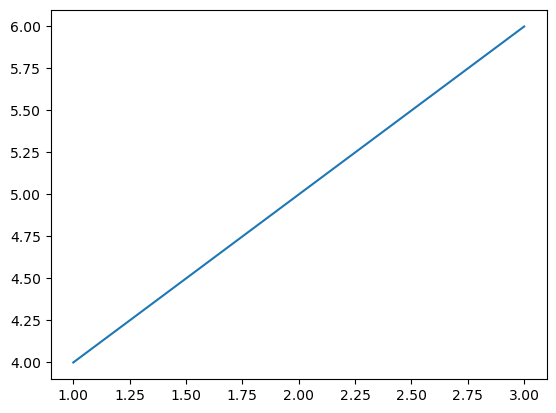

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

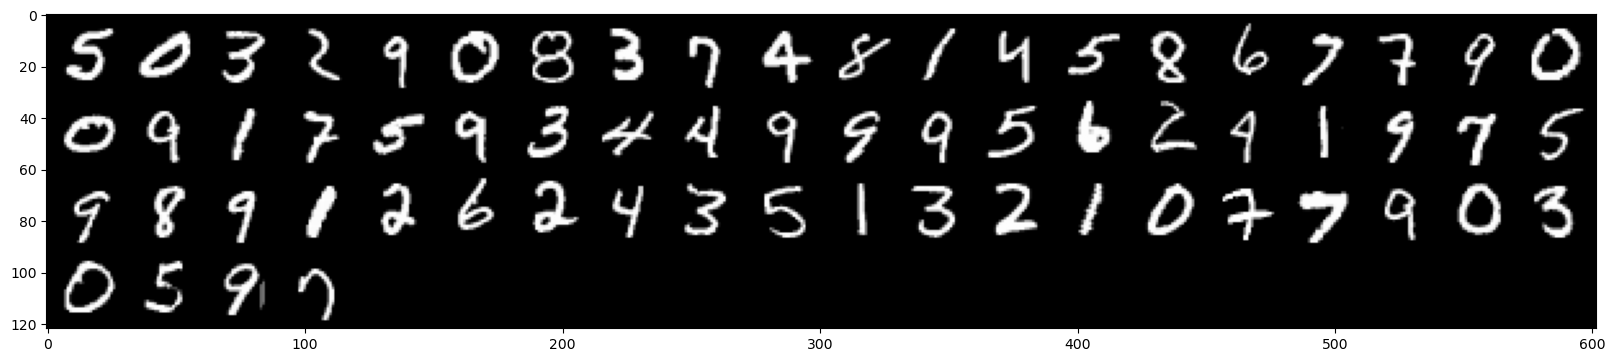

In [ ]:
images, lebels = next(iter(train_loader))
images.max()
#2. visiualize the data
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=20).permute(1,2,0).detach());


In [ ]:
#Class VAE():
"""
Contient une methode encoder() => mu, sigma = NeuralNetwork(x, y) (x' = torch.concatenate(x, y) et après mu, sigma = NN(x'));
Contient une méthode decoder() => mu, sigma = NeuralNetwork(z, y);
Contient une methode reparTrick(mu, sigma) => Loi normale, qui retourne z selon mu et sigma
Contient une methode forward() :
mu, sigma = encoder(x, y)
if train()
  z = reparTrick(mu, sigma)
  x' = decoder(z, y)
else:
  x' = decoder(mu, y)
return mu, sigma, z, x'

"""

#Training Part

#Calculate Loss : on a besoin des parametres de la classe VAE pour KL et
#pour la formule ==> L (ϕ, θ) = E q ϕ(z|x) [log p θ(x|z)] − KL(q ϕ(z|x) ||p(z))

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, discriminateur = False):
        super(MLP, self).__init__()
        layers = []
        current_size = input_size
        #boucle sur les tailles des couches cachées fournies dans hidden_sizes. Pour chaque taille :
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        if(discriminateur == True):
          layers.append(nn.Sigmoid())  # une fonction Sigmoid ici pour le discriminateur

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class VAE(nn.Module):
    def __init__(self, input_size, condition_size, hidden_sizes, latent_size, ):
        """
        Initialisation de l'encodeur et du decodeur, prise en compte de la taille des conditions et ajout à l'entrée de l'encodeur et du vecteur latent
        """
        super(VAE, self).__init__()
        self.encoder = MLP(input_size + condition_size, hidden_sizes, latent_size * 2)
        #l'architecture de l'encodeur est le miroir de celle du décodeur, c'est-à-dire que si l'encodeur diminue progressivement en taille (par exemple, de 512 à 256 unités pour les couches cachées),
        #alors le décodeur devrait augmenter progressivement (de 256 à 512 unités). !!!!!!!!!!!!!!!!!!!!
        self.decoder = MLP(latent_size + condition_size, hidden_sizes[::-1], input_size)

    def encode(self, x, y):
        #Permet d'obtenir mu et sigma
        combined = torch.cat([x, y], dim=1)
        mu_sigma = self.encoder(combined)
        mu, sigma = torch.chunk(mu_sigma, 2, dim=1)
        return mu, sigma

    def reparameterize(self, mu, sigma):
        # permet de propager le gradient à travers le processus stochastique en utilisant une variable epsilon standard normale.
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # La décodification est effectuée en concaténant le vecteur latent z avec les conditions y
        combined = torch.cat([z, y], dim=1)
        reconstruction = self.decoder(combined)
        return torch.sigmoid(reconstruction)  # Apply sigmoid

    def forward(self, x, y, training=True):
        # implémente la logique complète du processus d'encodage, de reparamétrisation et de décodage, et peut alterner entre les modes d'entraînement et de test
        mu, sigma = self.encode(x, y)
        if training:
            z = self.reparameterize(mu, sigma)
        else:
            z = mu
        x_prime = self.decode(z, y)
        return mu, sigma, z, x_prime

    def generate_samples(self, z, y):
        """Génère des échantillons en utilisant le décodeur du cVAE."""
        with torch.no_grad():
            samples = self.decode(z, y)
        return samples




def vae_loss(reconstructed_x, x, mu, sigma, beta=5.0):
    # Reconstruction loss (MSE or BCE) (if decoder follows normal distribution)
    #recon_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    recon_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction="sum")

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

    # E[log P(X|z,y)]
    # D_KL(Q(z|X,y) || P(z|X)); calculate in closed form as both dist. are Gaussian

    return recon_loss + beta * kl_div

    """
    input_size = 784  # Example for flattened 28x28 images
    condition_size = 10  # Example for 10 classes
    hidden_sizes = [512, 256]  # Example hidden layer sizes
    latent_size = 20  # Size of the latent space

    vae = VAE(input_size, condition_size, hidden_sizes, latent_size)
    """

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Discriminator, self).__init__()
        self.model = MLP(input_size, hidden_sizes, 1, True)  # Utilisation du MLP mis en place

    def forward(self, x):
        x = self.model(x)  # Utilisation du MLP
        return torch.sigmoid(x)  # Il faut que la sortie soit une probabilité




In [ ]:
import torch
from torch.autograd import Variable

import torch
import torch.nn.functional as F
# Function to flip labels with some probability
def flip_labels(labels, p=0.05):
    # With probability 'p', flip the labels
    mask = torch.rand(labels.size()) < p
    flipped_labels = torch.abs(1 - labels)  # flip labels
    return torch.where(mask, flipped_labels, labels)


def train_gan(cVAE, discriminator, data_loader, num_epochs, d_optimizer, g_optimizer, beta=5.0, C=10):
    cVAE.train()
    discriminator.train()
    """
    La boucle itère sur les époques et les données. À chaque batch, elle entraîne le discriminateur sur les vraies et
    fausses données, puis entraîne le générateur pour essayer de tromper le discriminateur.
    """
    for epoch in range(num_epochs):
        total_loss_d_real, total_loss_d_fake, total_loss_g = 0, 0, 0
        for x, labels in data_loader:
            N = x.size(0)

            # Préparer les données réelles
            real_data = x.view(-1, 784)  # Aplatir les images MNIST
            #real_labels = torch.ones(N, 1)
            #fake_labels = torch.zeros(N, 1)  # Étiquettes pour les données fausses

            # Soft labels
            real_labels = torch.full((N,1), 0.9)  #
            fake_labels = torch.full((N,1), 0.1)  #

             # Introduce label noise by occasionally flipping labels
            real_labels = flip_labels(real_labels, p=0.05)
            fake_labels = flip_labels(fake_labels, p=0.05)

            # Préparer les conditions y
            y = F.one_hot(labels, num_classes=10).type(torch.float32)  # Exemple pour MNIST

            # Entraîner le Discriminateur
            # Réelles
            real_decision = discriminator(real_data)
            loss_d_real = F.binary_cross_entropy(real_decision, real_labels)

            # Fausses
            _, _, _, fake_data = cVAE(real_data, y)  # Utilisation de votre cVAE
            fake_decision = discriminator(fake_data.detach())
            loss_d_fake = F.binary_cross_entropy(fake_decision, fake_labels)


            # Mise à jour du discriminateur
            d_optimizer.zero_grad()
            loss_d = (loss_d_real + loss_d_fake) / 2
            loss_d.backward()
            d_optimizer.step()

            # Entraîner le Générateur (cVAE)
            fake_decision = discriminator(fake_data)
            loss_g = F.binary_cross_entropy(fake_decision, real_labels)  # Tromper le discriminateur

            # Mise à jour du générateur
            g_optimizer.zero_grad()
            x = x.view(x.size(0), -1)  # Flatten les données
            y = F.one_hot(labels, C).float()
            mu, sigma, z, x_prime = cVAE(x, y)
            loss_g = vae_loss(x_prime, x, mu, sigma, beta)
            loss_g.backward()
            g_optimizer.step()

            # Enregistrer les pertes pour des statistiques détaillées
            total_loss_d_real += loss_d_real.item()
            total_loss_d_fake += loss_d_fake.item()
            total_loss_g += loss_g.item()

        # Calculer les moyennes des pertes pour l'époque
        avg_loss_d_real = total_loss_d_real / len(data_loader)
        avg_loss_d_fake = total_loss_d_fake / len(data_loader)
        avg_loss_g = total_loss_g / len(data_loader)

        # Imprimer les détails des pertes
        print(f"Epoch {epoch}/{num_epochs}, Average Losses => Discriminator (Real: {avg_loss_d_real}, Fake: {avg_loss_d_fake}), Generator: {avg_loss_g}")


# Paramètres et lancement de l'entraînement
input_size = 784
condition_size = 10
hidden_sizes = [512, 256]
latent_size = 50
num_epochs = 100

cVAE = VAE(input_size, condition_size, hidden_sizes, latent_size)
discriminator = Discriminator(input_size, hidden_sizes)

d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(cVAE.parameters(), lr=0.001)

train_gan(cVAE, discriminator, train_loader, num_epochs, d_optimizer, g_optimizer)



Epoch 0/100, Average Losses => Discriminator (Real: 0.5442891239738668, Fake: 0.9053002879944946), Generator: 11392.512083138992
Epoch 1/100, Average Losses => Discriminator (Real: 0.5450168004168122, Fake: 0.9040175055517062), Generator: 9797.427142503166
Epoch 2/100, Average Losses => Discriminator (Real: 0.5448566419737679, Fake: 0.9023699560907604), Generator: 9472.535376445063
Epoch 3/100, Average Losses => Discriminator (Real: 0.545380720515241, Fake: 0.9012487833815088), Generator: 9315.680617733042
Epoch 4/100, Average Losses => Discriminator (Real: 0.5461493353726767, Fake: 0.900251808641816), Generator: 9187.99991150553
Epoch 5/100, Average Losses => Discriminator (Real: 0.5461282175995393, Fake: 0.899385407535252), Generator: 9114.891911293143
Epoch 6/100, Average Losses => Discriminator (Real: 0.5465021825421339, Fake: 0.8985409060520912), Generator: 9063.917847460521
Epoch 7/100, Average Losses => Discriminator (Real: 0.548400661775044, Fake: 0.8984826971600051), Generator

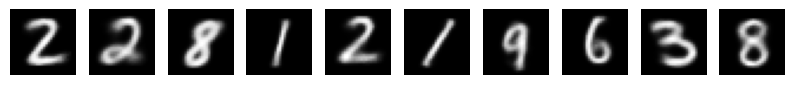

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_cVAE_samples(cVAE, num_samples=10):
    cVAE.eval()  # Passer en mode évaluation
    with torch.no_grad():
        # Générer des conditions y si nécessaire (ici des chiffres aléatoires pour MNIST par exemple)
        y = torch.randint(0, 10, (num_samples,)).type(torch.long)
        y = F.one_hot(y, num_classes=10).type(torch.float32)

        # Générer des données fausses
        z = torch.randn(num_samples, latent_size)
        fake_images = cVAE.decode(z, y).view(-1, 28, 28)  # A vérifier

        # Visualiser les images
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
        for img, ax in zip(fake_images, axes):
            ax.imshow(img.cpu().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()

visualize_cVAE_samples(cVAE)
